<a href="https://colab.research.google.com/github/varunav123/ImageColouriser/blob/master/IC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: val_256/valid_samples/Places365_val_00011667.jpg  
  inflating: val_256/valid_samples/Places365_val_00011671.jpg  
  inflating: val_256/valid_samples/Places365_val_00011679.jpg  
  inflating: val_256/valid_samples/Places365_val_00011681.jpg  
  inflating: val_256/valid_samples/Places365_val_00011686.jpg  
  inflating: val_256/valid_samples/Places365_val_00011689.jpg  
  inflating: val_256/valid_samples/Places365_val_00011690.jpg  
  inflating: val_256/valid_samples/Places365_val_00011696.jpg  
  inflating: val_256/valid_samples/Places365_val_00011697.jpg  
  inflating: val_256/valid_samples/Places365_val_00011702.jpg  
  inflating: val_256/valid_samples/Places365_val_00011703.jpg  
  inflating: val_256/valid_samples/Places365_val_00011706.jpg  
  inflating: val_256/valid_samples/Places365_val_00011717.jpg  
  inflating: val_256/valid_samples/Places365_val_00011718.jpg  
  inflating: val_256/valid_samples/Places365_val_0001

In [4]:
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
import time

from tensorflow import keras



In [5]:
tf.config.run_functions_eagerly(True)

# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 120

# These many images will be used from the data archive
dataset_split = 2500

master_dir = 'val_256/train_samples'
x = []
y = []
for image_file in os.listdir(master_dir)[:dataset_split]:
    rgb_image = cv.imread(os.path.join(master_dir, image_file))
    rgb_image = cv.cvtColor(rgb_image, cv.COLOR_BGR2RGB)
    rgb_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2LAB)
    rgb_image = cv.resize(rgb_image, (img_size, img_size))
    rgb_img_array = rgb_image.astype(np.float32) / 255.0


    gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY)
    gray_image = gray_image.reshape((img_size, img_size, 1))
    gray_img_array = gray_image.astype(np.float32) / 255.0

    x.append(gray_img_array)
    y.append(rgb_img_array)

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size=0.1)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)

# **Generator Model based on Unet architecture, initial layers being the downsamplers, leading up to the bottleneck, and the later layers being the upsamplers.**

In [18]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model


# **Discriminator Model based on the PatchGAN model**

In [14]:

from tensorflow.keras.layers import Conv2D

def get_discriminator_model():
    layers = [
        Conv2D(32, kernel_size=(7, 7), strides=2, activation='relu', input_shape=(120, 120, 3)),
        Conv2D(64, kernel_size=(5, 5), strides=2, activation='relu'),
        Conv2D(128, kernel_size=(3, 3), strides=2, activation='relu'),
        Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu'),
    ]

    inputs = tf.keras.Input(shape=(120, 120, 3))
    x = inputs
    for layer in layers:
        x = layer(x)

    # PatchGAN discriminator output
    patch_output = Conv2D(1, kernel_size=(3, 3), strides=1, activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(inputs=inputs, outputs=patch_output)
    return model

# Example usage
discriminator = get_discriminator_model()
discriminator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 57, 57, 32)        4736      
                                                                 
 conv2d_24 (Conv2D)          (None, 27, 27, 64)        51264     
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 conv2d_26 (Conv2D)          (None, 11, 11, 256)       295168    
                                                                 
 conv2d_27 (Conv2D)          (None, 11, 11, 1)         2305      
                                                                 
Total params: 427,329
Trainable params: 427,329
Non-trainab

# **Defining the loss as stated in the pix2pix paper**

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()

In [20]:
@tf.function
def train_step( input_x , real_y ):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)

        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )

        losses["D"].append(disc_loss.numpy())
        losses["G"].append(gen_loss.numpy())
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

generator.compile(
    optimizer=generator_optimizer,
    loss=generator_loss,
    metrics=['accuracy']
)

discriminator.compile(
    optimizer=discriminator_optimizer,
    loss=discriminator_loss,
    metrics=['accuracy']
)


In [21]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    g_loss = []
    d_loss = []

    count = 0
    for i in losses['D']:
      count += 1
      if(count == 36):
        d_loss.append(i)
        count = 0

    count = 0
    for i in losses['G']:
      count += 1
      if(count == 36):
        g_loss.append(i)
        count = 0

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [22]:
# Please have a look at the Notebook in pdf form that was train on 150 epoc.
num_epochs = 200
losses = {"D":[], "G":[]}
for e in range( num_epochs ):
    print("Running epoch : ", e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        # print( x.shape )
        train_step( x , y )

Running epoch :  0
Running epoch :  1
Running epoch :  2
Running epoch :  3
Running epoch :  4
Running epoch :  5
Running epoch :  6
Running epoch :  7
Running epoch :  8
Running epoch :  9
Running epoch :  10
Running epoch :  11
Running epoch :  12
Running epoch :  13
Running epoch :  14
Running epoch :  15
Running epoch :  16
Running epoch :  17
Running epoch :  18
Running epoch :  19
Running epoch :  20
Running epoch :  21
Running epoch :  22
Running epoch :  23
Running epoch :  24
Running epoch :  25
Running epoch :  26
Running epoch :  27
Running epoch :  28
Running epoch :  29
Running epoch :  30
Running epoch :  31
Running epoch :  32
Running epoch :  33
Running epoch :  34
Running epoch :  35
Running epoch :  36
Running epoch :  37
Running epoch :  38
Running epoch :  39
Running epoch :  40
Running epoch :  41
Running epoch :  42
Running epoch :  43
Running epoch :  44
Running epoch :  45
Running epoch :  46
Running epoch :  47
Running epoch :  48
Running epoch :  49
Running ep

KeyboardInterrupt: ignored

In [23]:
y = generator( test_x[0 : ] ).numpy()

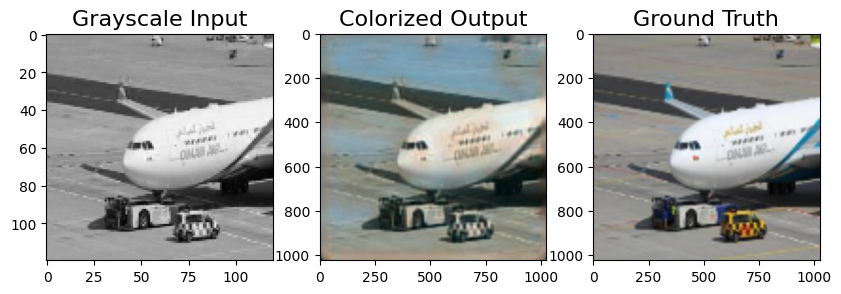

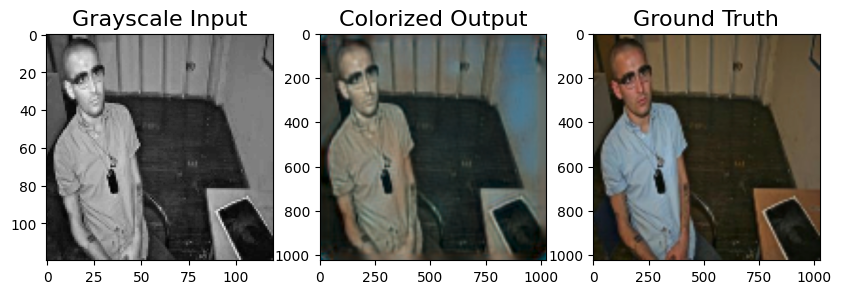

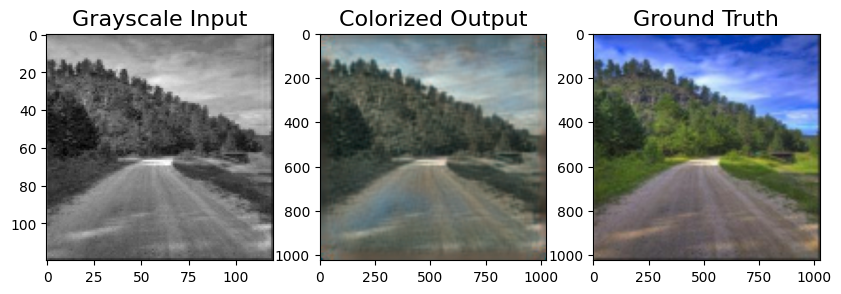

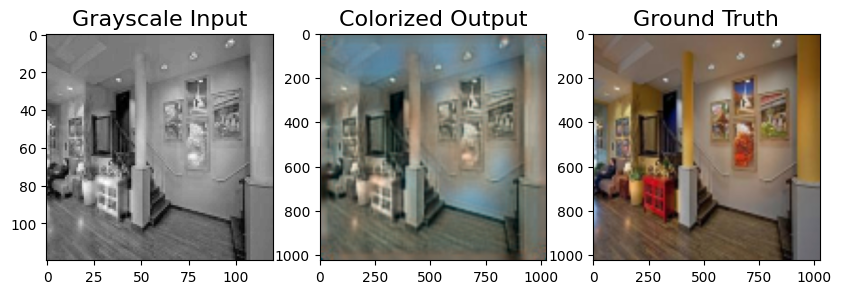

In [24]:
for i in range(11, 33, 7):
    plt.figure(figsize=(10, 10))

    or_image = plt.subplot(3, 3, 1)
    or_image.set_title('Grayscale Input', fontsize=16)
    plt.imshow(test_x[i].reshape((120, 120)), cmap='gray')

    in_image = plt.subplot(3, 3, 2)
    image = cv.resize((y[i] * 255).astype('uint8'), (1024, 1024))
    in_image.set_title('Colorized Output', fontsize=16)
    plt.imshow(cv.cvtColor(image, cv.COLOR_LAB2RGB))

    ou_image = plt.subplot(3, 3, 3)
    image = cv.resize((test_y[i] * 255).astype('uint8'), (1024, 1024))
    ou_image.set_title('Ground Truth', fontsize=16)
    plt.imshow(cv.cvtColor(image, cv.COLOR_LAB2RGB))

    plt.show()


In [26]:
generator.save_weights('generator_weights.h5')
discriminator.save_weights('discriminator_weights.h5')